#### Analyzing Neural Time Series Data
Python code for Chapter 27 -- converted from original Matlab by AE Studio (and ChatGPT)\
Original Matlab code by Mike X Cohen

This code accompanies the book, titled "Analyzing Neural Time Series Data" (MIT Press).\
Using the code without following the book may lead to confusion, incorrect data analyses, and misinterpretations of results.\
Mike X Cohen and AE Studio assume no responsibility for inappropriate or incorrect use of this code.

In [30]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, kstest, rankdata
from scipy.io import loadmat
from scipy.signal import correlate, correlation_lags

In [2]:
# an aside on covariance and correlation

a = np.random.randn(100)
b = np.random.randn(100)

corr1 = np.corrcoef(a, b)[0, 1]

a1 = a - np.mean(a)
b1 = b - np.mean(b)
corr2 = (a1 @ b1.T) / np.sqrt((a1 @ a1.T) * (b1 @ b1.T))

c = np.vstack((a1, b1))
covmat = c @ c.T

# notice the following:
print(covmat[0, 0] == a1 @ a1.T)
print(covmat[1, 1] == b1 @ b1.T)
print(covmat[1, 0] == a1 @ b1.T)
# actually, some of these might not be exactly equal due to very small computer rounding errors.
# try this instead:
print((covmat[1, 0] - a1 @ b1.T) < 1e-14)

corr3 = covmat[0, 1] / np.sqrt(covmat[0, 0] * covmat[1, 1])

print(f"\nPython numpy.corrcoef function: {corr1}")
print(f"covariance scaled by variances: {corr2}")
print(f"covariance computed as matrix: {corr3}\n")

True
False
True
True

Python numpy.corrcoef function: 0.09244173446224686
covariance scaled by variances: 0.09244173446224686
covariance computed as matrix: 0.09244173446224685



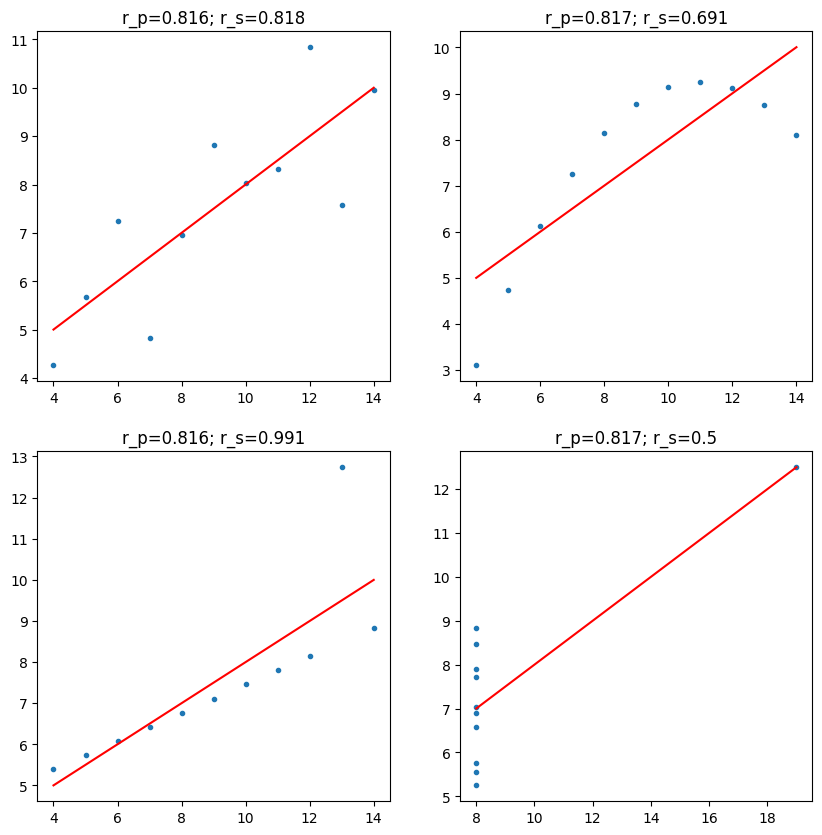

In [3]:
# Figure 27.1

anscombe = np.array([
    # series 1    series 2    series 3     series 4
    [10, 8.04,    10, 9.14,    10, 7.46,     8, 6.58],
    [8, 6.95,     8, 8.14,     8, 6.77,     8, 5.76],
    [13, 7.58,    13, 8.76,    13, 12.74,    8, 7.71],
    [9, 8.81,     9, 8.77,     9, 7.11,     8, 8.84],
    [11, 8.33,    11, 9.26,    11, 7.81,     8, 8.47],
    [14, 9.96,    14, 8.10,    14, 8.84,     8, 7.04],
    [6, 7.24,     6, 6.13,     6, 6.08,     8, 5.25],
    [4, 4.26,     4, 3.10,     4, 5.39,     8, 5.56],
    [12, 10.84,   12, 9.13,    12, 8.15,     8, 7.91],
    [7, 4.82,     7, 7.26,     7, 6.42,     8, 6.89],
    [5, 5.68,     5, 4.74,     5, 5.73,    19, 12.50],
])

# plot and compute correlations
plt.figure(figsize=(10, 10))
for i in range(1, 5):
    plt.subplot(2, 2, i)
    x = anscombe[:, (i - 1) * 2]
    y = anscombe[:, (i - 1) * 2 + 1]
    plt.plot(x, y, '.')
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='red')
    corr_p, _ = pearsonr(x, y)
    corr_s, _ = spearmanr(x, y)
    plt.title(f'r_p={round(corr_p, 3)}; r_s={round(corr_s, 3)}')
plt.show()

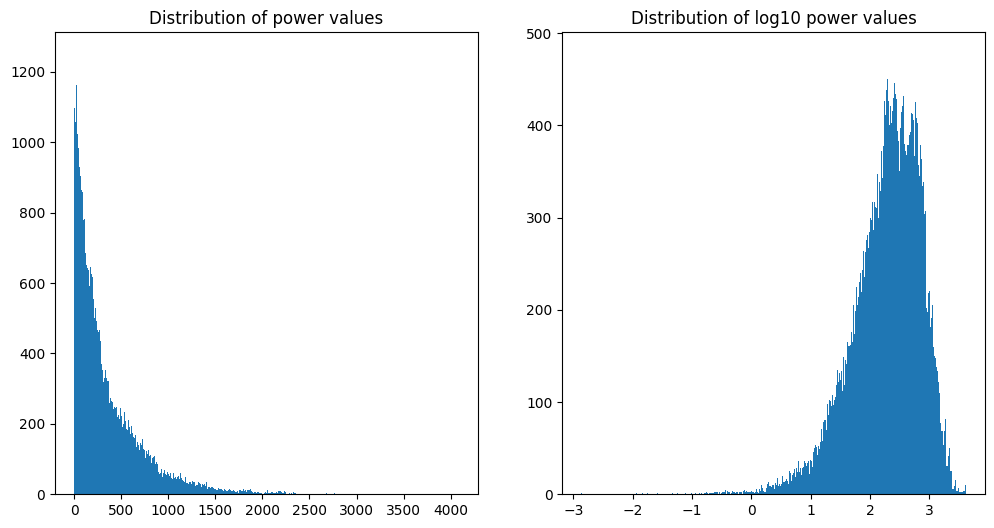

KS test for normality of power: 0.0 (>.05 means normal distribution)
KS test for normality of log10(power): 0.0 (>.05 means normal distribution)
KS test for normality of random data: 0.3290847530734744 (>.05 means normal distribution)


In [11]:
# Figure 27.2

# Load EEG data
eeg_data = loadmat('../data/sampleEEGdata.mat')
EEG = eeg_data['EEG'][0, 0]  # Assuming the data is stored in this way

sensor2use = 'Fz'
centerfreq = 10  # in Hz

# setup wavelet convolution and outputs
srate = EEG['srate'][0, 0]
time = np.arange(-1, 1 + 1/srate, 1/srate)
half_of_wavelet_size = (len(time) - 1) // 2

# FFT parameters
n_wavelet = len(time)
n_data = EEG['pnts'][0, 0] * EEG['trials'][0, 0]
n_convolution = n_wavelet + n_data - 1
wavelet_cycles = 4.5

# Find the index of the sensor to use
sensor_idx = EEG['chanlocs'][0]['labels']==sensor2use

# FFT of data (note: this doesn't change on frequency iteration)
fft_data = np.fft.fft(np.reshape(EEG['data'][sensor_idx, :, :], (1, n_data), 'F'), n_convolution)

# create wavelet and run convolution
fft_wavelet = np.fft.fft(np.exp(2 * 1j * np.pi * centerfreq * time) * np.exp(-time ** 2 / (2 * (wavelet_cycles / (2 * np.pi * centerfreq)) ** 2)), n_convolution)
convolution_result_fft = np.fft.ifft(fft_wavelet * fft_data, n_convolution) * np.sqrt(wavelet_cycles / (2 * np.pi * centerfreq))
convolution_result_fft = convolution_result_fft[0][half_of_wavelet_size: -half_of_wavelet_size]
convolution_result_fft = np.abs(np.reshape(convolution_result_fft, (EEG['pnts'][0, 0], EEG['trials'][0, 0]), 'F')) ** 2

# trim edges so the distribution is not driven by edge artifact outliers
convolution_result_fft = convolution_result_fft[100:-100, :]

# plot distribution of power data
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.hist(convolution_result_fft.flatten(), bins=500)
plt.title('Distribution of power values')

plt.subplot(122)
plt.hist(np.log10(convolution_result_fft.flatten()), bins=500)
plt.title('Distribution of log10 power values')
plt.show()

# test for normal distribution, if you have the stats toolbox
if 'kstest' in dir():
    p1 = kstest(convolution_result_fft.flatten(), 'norm')[1]
    p2 = kstest(np.log10(convolution_result_fft.flatten()), 'norm')[1]
    p3 = kstest(np.random.randn(convolution_result_fft.size), 'norm')[1]
    print(f'KS test for normality of power: {p1} (>.05 means normal distribution)')
    print(f'KS test for normality of log10(power): {p2} (>.05 means normal distribution)')
    print(f'KS test for normality of random data: {p3} (>.05 means normal distribution)')

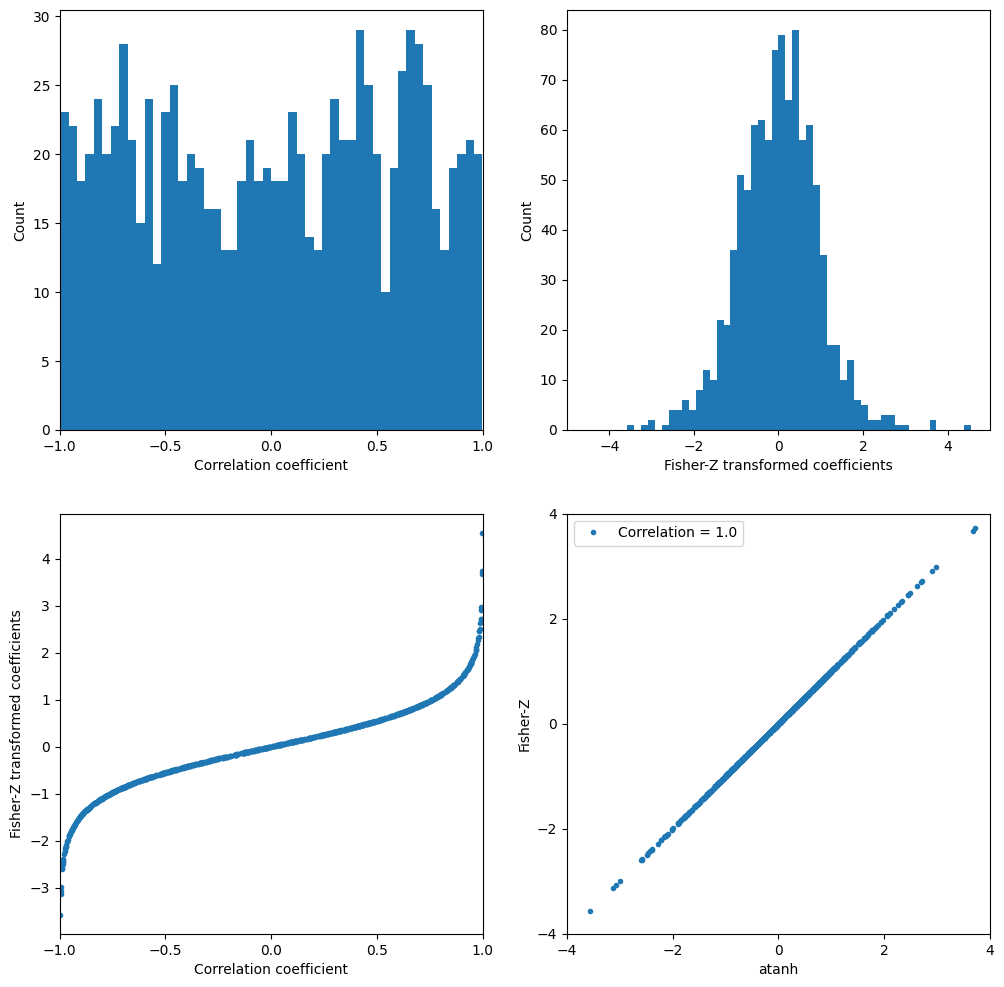

In [13]:
# Figure 27.3

# Fisher Z transformation
lots_of_corr_coefs = np.random.rand(1000) * 2 - 1
fisher_z_coefs = 0.5 * np.log((1 + lots_of_corr_coefs) / (1 - lots_of_corr_coefs))

plt.figure(figsize=(12, 12))

# Histogram of correlation coefficients
plt.subplot(221)
plt.hist(lots_of_corr_coefs, 50)
plt.xlabel('Correlation coefficient')
plt.ylabel('Count')
plt.xlim([-1, 1])
plt.xticks(np.arange(-1, 1.5, 0.5))

# Histogram of Fisher-Z transformed coefficients
plt.subplot(222)
plt.hist(fisher_z_coefs, 50)
plt.xlabel('Fisher-Z transformed coefficients')
plt.ylabel('Count')
plt.xlim([-5, 5])
plt.xticks(np.arange(-4, 5, 2))

# Scatter plot of correlation coefficients vs. Fisher-Z transformed coefficients
plt.subplot(223)
plt.plot(lots_of_corr_coefs, fisher_z_coefs, '.')
plt.xlabel('Correlation coefficient')
plt.ylabel('Fisher-Z transformed coefficients')
plt.xlim([-1, 1])
plt.xticks(np.arange(-1, 1.5, 0.5))

# Scatter plot of atanh (inverse Fisher-Z) vs. Fisher-Z
plt.subplot(224)
plt.plot(np.arctanh(lots_of_corr_coefs), fisher_z_coefs, '.')
plt.xlabel('atanh')
plt.ylabel('Fisher-Z')
r = np.corrcoef(np.arctanh(lots_of_corr_coefs), fisher_z_coefs)[0, 1]
plt.legend([f'Correlation = {r}'])
plt.xticks(np.arange(-4, 5, 2))
plt.yticks(np.arange(-4, 5, 2))
plt.axis([-4, 4, -4, 4])
plt.show()

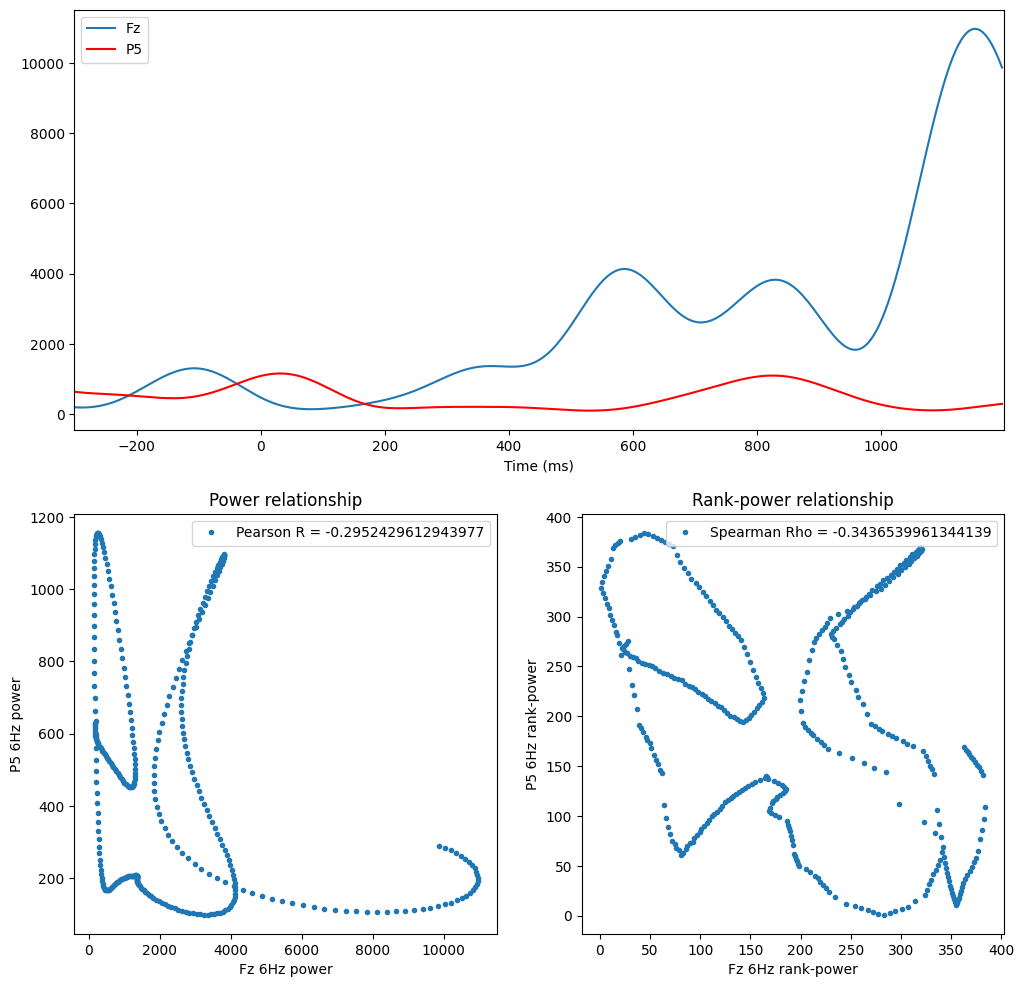

In [20]:
# Figure 27.4

# Define sensors and frequencies
sensor1 = 'Fz'
sensor2 = 'P5'
centerfreq = 6  # in Hz
trial2plot = 10

# Find the indices of the sensors to use
sensor1_idx = EEG['chanlocs'][0]['labels']==sensor1
sensor2_idx = EEG['chanlocs'][0]['labels']==sensor2

# FFT of data for both sensors
fft_data1 = np.fft.fft(np.reshape(EEG['data'][sensor1_idx, :, :], (1, n_data), 'F'), n_convolution)
fft_data2 = np.fft.fft(np.reshape(EEG['data'][sensor2_idx, :, :], (1, n_data), 'F'), n_convolution)

# Create wavelet and run convolution for both sensors
fft_wavelet = np.fft.fft(np.exp(2 * 1j * np.pi * centerfreq * time) * np.exp(-time ** 2 / (2 * (wavelet_cycles / (2 * np.pi * centerfreq)) ** 2)), n_convolution)

# Convolution for sensor 1
convolution_result_fft1 = np.fft.ifft(fft_wavelet * fft_data1, n_convolution) * np.sqrt(wavelet_cycles / (2 * np.pi * centerfreq))
convolution_result_fft1 = convolution_result_fft1[0][half_of_wavelet_size: -half_of_wavelet_size]
convolution_result_fft1 = np.abs(np.reshape(convolution_result_fft1, (EEG['pnts'][0, 0], EEG['trials'][0, 0]), 'F')) ** 2

# Convolution for sensor 2
convolution_result_fft2 = np.fft.ifft(fft_wavelet * fft_data2, n_convolution) * np.sqrt(wavelet_cycles / (2 * np.pi * centerfreq))
convolution_result_fft2 = convolution_result_fft2[0][half_of_wavelet_size: -half_of_wavelet_size]
convolution_result_fft2 = np.abs(np.reshape(convolution_result_fft2, (EEG['pnts'][0, 0], EEG['trials'][0, 0]), 'F')) ** 2

# Keep only requested time regions
times2plot = np.array([-300, 1200])  # Define the time window you want to plot
times2plot_idx = np.array([np.argmin(np.abs(EEG['times'][0] - t)) for t in times2plot])

convolution_result_fft1 = convolution_result_fft1[times2plot_idx[0]:times2plot_idx[1], :]
convolution_result_fft2 = convolution_result_fft2[times2plot_idx[0]:times2plot_idx[1], :]

# Plotting the power values and their relationship
plt.figure(figsize=(12, 12))
plt.subplot(211)
plt.plot(EEG['times'][0][times2plot_idx[0]:times2plot_idx[1]], convolution_result_fft1[:, trial2plot])
plt.plot(EEG['times'][0][times2plot_idx[0]:times2plot_idx[1]], convolution_result_fft2[:, trial2plot], 'r')
plt.xlabel('Time (ms)')
plt.xlim(EEG['times'][0][times2plot_idx])
plt.legend([sensor1, sensor2])

plt.subplot(223)
plt.plot(convolution_result_fft1[:, trial2plot], convolution_result_fft2[:, trial2plot], '.')
plt.title('Power relationship')
plt.xlabel(f'{sensor1} {centerfreq}Hz power')
plt.ylabel(f'{sensor2} {centerfreq}Hz power')
r = np.corrcoef(convolution_result_fft1[:, trial2plot], convolution_result_fft2[:, trial2plot])[0, 1]
plt.legend([f'Pearson R = {r}'])

plt.subplot(224)
plt.plot(rankdata(convolution_result_fft1[:, trial2plot]), rankdata(convolution_result_fft2[:, trial2plot]), '.')
plt.title('Rank-power relationship')
plt.xlabel(f'{sensor1} {centerfreq}Hz rank-power')
plt.ylabel(f'{sensor2} {centerfreq}Hz rank-power')
r_spearman = spearmanr(convolution_result_fft1[:, trial2plot], convolution_result_fft2[:, trial2plot])[0]
plt.legend([f'Spearman Rho = {r_spearman}'])
plt.ylim(plt.xlim())
plt.show()

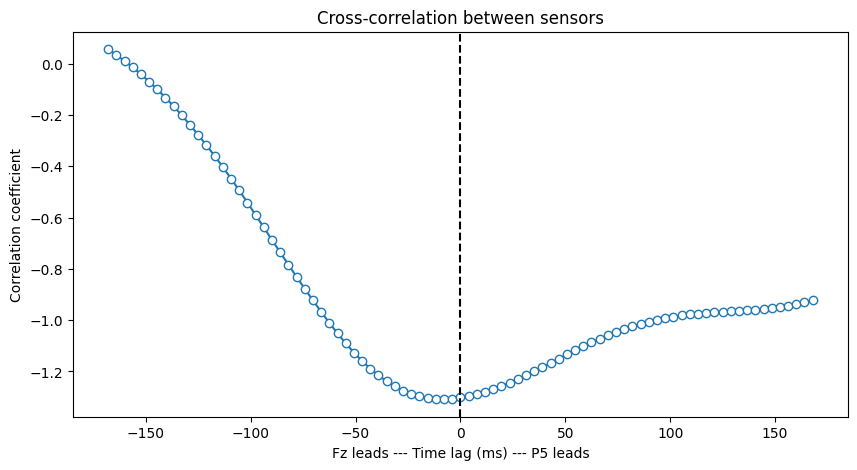

In [33]:
# Figure 27.5

# Compute how many time points are in one cycle, and limit xcov to this lag
nlags = round(srate / centerfreq)

# Compute the cross-correlation using the power values
power1 = np.abs(np.reshape(convolution_result_fft1, (EEG['pnts'][0, 0], EEG['trials'][0, 0]), 'F')[:, trial2plot]) ** 2
power2 = np.abs(np.reshape(convolution_result_fft2, (EEG['pnts'][0, 0], EEG['trials'][0, 0]), 'F')[:, trial2plot]) ** 2

# Rank transform the power values
rank_power1 = rankdata(power1)
rank_power2 = rankdata(power2)

# Compute cross-correlation
corrvals = correlate(rank_power1 - np.mean(rank_power1), 
                            rank_power2 - np.mean(rank_power2), 
                            mode='full')
lags = correlation_lags(len(rank_power1), len(rank_power2), mode='full')
corrlags = lags / srate * 1000  # Convert lags to milliseconds

# Normalize the cross-correlation values
corrvals = corrvals / np.max(corrvals)

# Find the center index corresponding to zero lag
center_idx = np.where(lags == 0)[0][0]

# Plot the cross-correlation
plt.figure(figsize=(10, 5))
plt.plot(corrlags[center_idx - nlags:center_idx + nlags + 1], 
         corrvals[center_idx - nlags:center_idx + nlags + 1], '-o', markerfacecolor='w')
plt.axvline(0, color='k', linestyle='--')
plt.xlabel(f'{sensor1} leads --- Time lag (ms) --- {sensor2} leads')
plt.ylabel('Correlation coefficient')
plt.title('Cross-correlation between sensors')
plt.show()

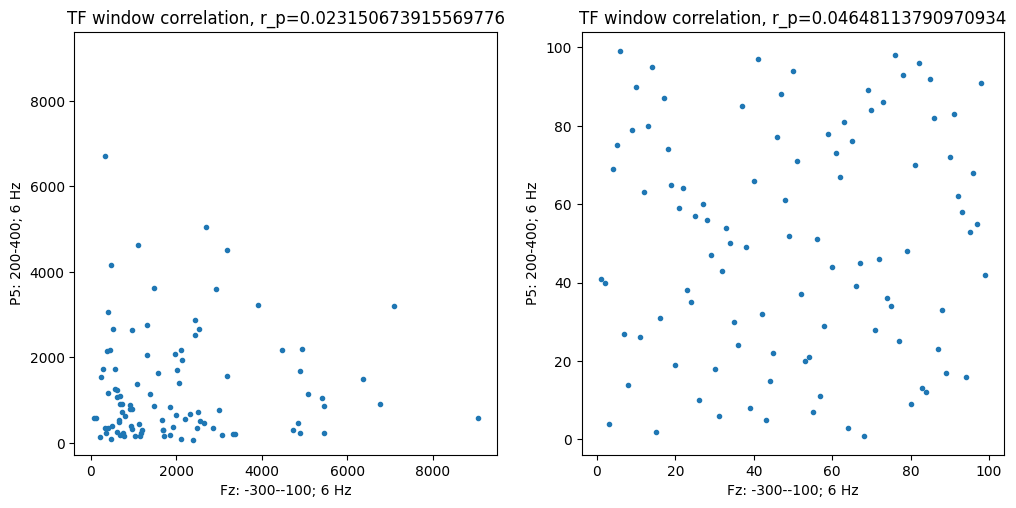

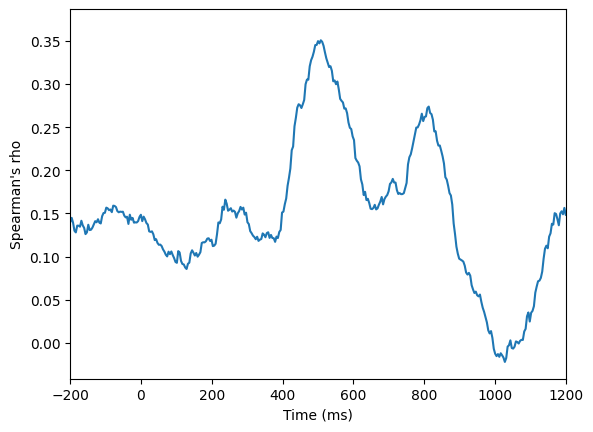

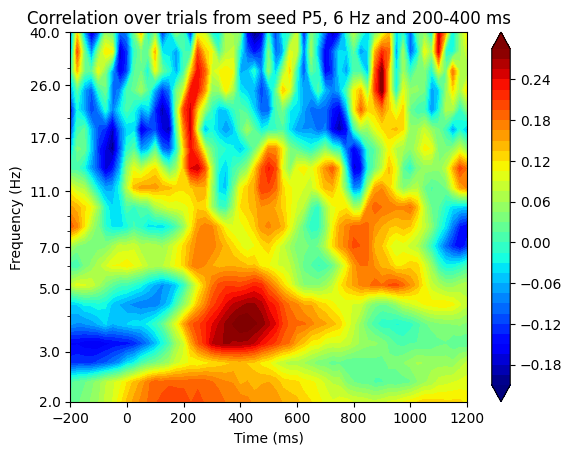

In [28]:
# Figure 27.6

# Define time windows and frequencies
timewin1 = [-300, -100]  # in ms relative to stim onset
timewin2 = [200, 400]
centerfreq1 = 6  # in Hz
centerfreq2 = 6

# Convert time from ms to index
timeidx1 = [np.argmin(np.abs(EEG['times'][0] - t)) for t in timewin1]
timeidx2 = [np.argmin(np.abs(EEG['times'][0] - t)) for t in timewin2]

# Create wavelet and run convolution for both sensors
fft_wavelet1 = np.fft.fft(np.exp(2 * 1j * np.pi * centerfreq1 * time) * np.exp(-time ** 2 / (2 * (wavelet_cycles / (2 * np.pi * centerfreq1)) ** 2)), n_convolution)
fft_wavelet2 = np.fft.fft(np.exp(2 * 1j * np.pi * centerfreq2 * time) * np.exp(-time ** 2 / (2 * (wavelet_cycles / (2 * np.pi * centerfreq2)) ** 2)), n_convolution)

# Convolution for sensor 1
convolution_result_fft1 = np.fft.ifft(fft_wavelet1 * fft_data1, n_convolution) * np.sqrt(wavelet_cycles / (2 * np.pi * centerfreq1))
convolution_result_fft1 = convolution_result_fft1[0][half_of_wavelet_size: -half_of_wavelet_size]
analyticsignal1 = np.abs(np.reshape(convolution_result_fft1, (EEG['pnts'][0, 0], EEG['trials'][0, 0]), 'F')) ** 2

# Convolution for sensor 2
convolution_result_fft2 = np.fft.ifft(fft_wavelet2 * fft_data2, n_convolution) * np.sqrt(wavelet_cycles / (2 * np.pi * centerfreq2))
convolution_result_fft2 = convolution_result_fft2[0][half_of_wavelet_size: -half_of_wavelet_size]
analyticsignal2 = np.abs(np.reshape(convolution_result_fft2, (EEG['pnts'][0, 0], EEG['trials'][0, 0]), 'F')) ** 2

# Panel A: correlation in a specified window
tfwindowdata1 = np.mean(analyticsignal1[timeidx1[0]:timeidx1[1], :], axis=0)
tfwindowdata2 = np.mean(analyticsignal2[timeidx2[0]:timeidx2[1], :], axis=0)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(tfwindowdata1, tfwindowdata2, '.')
plt.axis('square')
plt.title(f'TF window correlation, r_p={pearsonr(tfwindowdata1, tfwindowdata2)[0]}')
plt.xlabel(f'{sensor1}: {timewin1[0]}-{timewin1[1]}; {centerfreq1} Hz')
plt.ylabel(f'{sensor2}: {timewin2[0]}-{timewin2[1]}; {centerfreq2} Hz')

# Also plot rank-transformed data
plt.subplot(122)
plt.plot(rankdata(tfwindowdata1), rankdata(tfwindowdata2), '.')
plt.axis('square')
plt.xlabel(f'{sensor1}: {timewin1[0]}-{timewin1[1]}; {centerfreq1} Hz')
plt.ylabel(f'{sensor2}: {timewin2[0]}-{timewin2[1]}; {centerfreq2} Hz')
plt.title(f'TF window correlation, r_p={spearmanr(tfwindowdata1, tfwindowdata2)[0]}')
plt.show()

# Panel B: correlation over time
corr_ts = np.array([spearmanr(analyticsignal1[ti, :], analyticsignal2[ti, :])[0] for ti in range(EEG['pnts'][0, 0])])

plt.figure()
plt.plot(EEG['times'][0], corr_ts)
plt.xlim([-200, 1200])
plt.xlabel('Time (ms)')
plt.ylabel("Spearman's rho")
plt.show()

# Panel C: exploratory time-frequency power correlations

# Define times and frequencies for exploration
times2save = np.arange(-200, 1201, 25)  # in ms
frex = np.logspace(np.log10(2), np.log10(40), 20)

# Convert times to indices
times2save_idx = np.array([np.argmin(np.abs(EEG['times'][0] - t)) for t in times2save])

# Rank-transforming the data can happen outside the frequency loop
seeddata_rank = rankdata(tfwindowdata2)

# Initialize output correlation matrix
expl_corrs = np.zeros((len(frex), len(times2save)))

for fi, freq in enumerate(frex):
    # Get power (via wavelet convolution) from signal1
    fft_wavelet = np.fft.fft(np.exp(2 * 1j * np.pi * freq * time) * np.exp(-time ** 2 / (2 * (wavelet_cycles / (2 * np.pi * freq)) ** 2)), n_convolution)
    convolution_result_fft = np.fft.ifft(fft_wavelet * fft_data1, n_convolution) * np.sqrt(wavelet_cycles / (2 * np.pi * freq))
    convolution_result_fft = convolution_result_fft[0][half_of_wavelet_size: -half_of_wavelet_size]
    analyticsignal1 = np.abs(np.reshape(convolution_result_fft, (EEG['pnts'][0, 0], EEG['trials'][0, 0]), 'F')) ** 2
    
    for ti, time_idx in enumerate(times2save_idx):
        expl_corrs[fi, ti] = 1 - 6 * np.sum((seeddata_rank - rankdata(analyticsignal1[time_idx, :])) ** 2) / (EEG['trials'][0, 0] * (EEG['trials'][0, 0] ** 2 - 1))

# Plot the exploratory time-frequency power correlations
plt.figure()
plt.contourf(times2save, frex, expl_corrs, 40, cmap='jet', extend='both')
plt.yscale('log')
plt.yticks(np.round(np.logspace(np.log10(frex[0]), np.log10(frex[-1]), 8)), np.round(np.logspace(np.log10(frex[0]), np.log10(frex[-1]), 8)))
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')
plt.title(f'Correlation over trials from seed {sensor2}, {centerfreq2} Hz and {timewin2[0]}-{timewin2[1]} ms')
plt.colorbar()
plt.show()

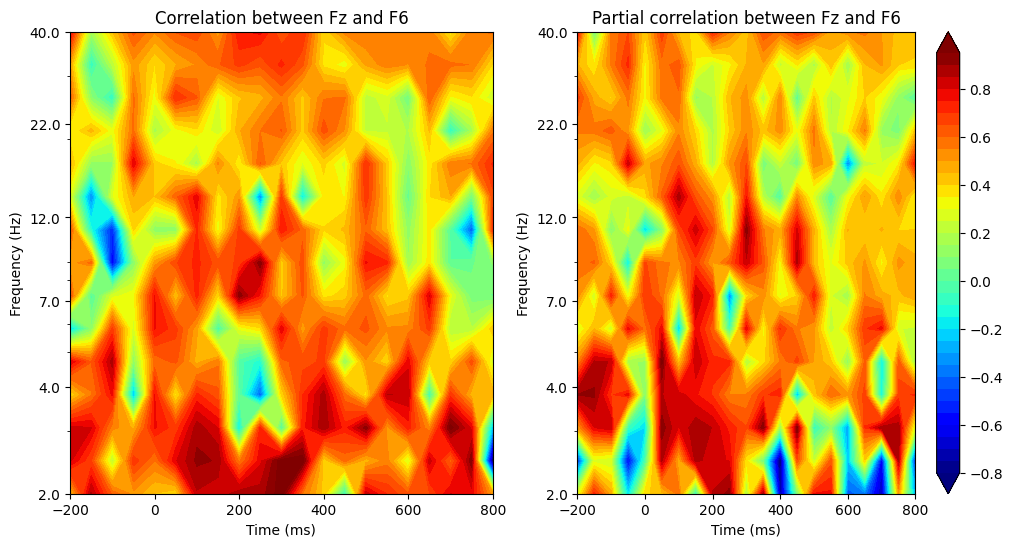

In [40]:
# Figure 27.7

# Define channels and parameters
seed_chan = 'Fz'
target_chan = 'F6'
control_chan = 'F1'
clim = [0, 0.6]

# Wavelet parameters
min_freq = 2
max_freq = 40
num_frex = 15

# Downsampled times
times2save = np.arange(-200, 801, 50)

# Other wavelet parameters
frequencies = np.logspace(np.log10(min_freq), np.log10(max_freq), num_frex)
times2saveidx = np.array([np.argmin(np.abs(EEG['times'][0] - t)) for t in times2save])

# FFT of data for seed, target, and control channels
fft_data_seed = np.fft.fft(np.reshape(EEG['data'][EEG['chanlocs'][0]['labels']==seed_chan, :, :], (1, n_data), 'F'), n_convolution)
fft_data_trgt = np.fft.fft(np.reshape(EEG['data'][EEG['chanlocs'][0]['labels']==target_chan, :, :], (1, n_data), 'F'), n_convolution)
fft_data_ctrl = np.fft.fft(np.reshape(EEG['data'][EEG['chanlocs'][0]['labels']==control_chan, :, :], (1, n_data), 'F'), n_convolution)

# Initialize output time-frequency data
tf_corrdata = np.zeros((len(frequencies), len(times2save), 2))

for fi, freq in enumerate(frequencies):
    # Create wavelet and get its FFT
    fft_wavelet = np.fft.fft(np.exp(2 * 1j * np.pi * freq * time) * np.exp(-time ** 2 / (2 * (wavelet_cycles / (2 * np.pi * freq)) ** 2)) / freq, n_convolution)
    
    # Convolution for seed, target, and control sites (save only power)
    conv_result_seed = np.abs(np.reshape(np.fft.ifft(fft_wavelet * fft_data_seed, n_convolution)[0][half_of_wavelet_size: -half_of_wavelet_size], (EEG['pnts'][0, 0], EEG['trials'][0, 0]), 'F')) ** 2
    conv_result_trgt = np.abs(np.reshape(np.fft.ifft(fft_wavelet * fft_data_trgt, n_convolution)[0][half_of_wavelet_size: -half_of_wavelet_size], (EEG['pnts'][0, 0], EEG['trials'][0, 0]), 'F')) ** 2
    conv_result_ctrl = np.abs(np.reshape(np.fft.ifft(fft_wavelet * fft_data_ctrl, n_convolution)[0][half_of_wavelet_size: -half_of_wavelet_size], (EEG['pnts'][0, 0], EEG['trials'][0, 0]), 'F')) ** 2
    
    # Downsample and rank transform all data
    conv_result_seed = rankdata(conv_result_seed[times2saveidx, :], axis=1)
    conv_result_trgt = rankdata(conv_result_trgt[times2saveidx, :], axis=1)
    conv_result_ctrl = rankdata(conv_result_ctrl[times2saveidx, :], axis=1)
    
    for ti, time_idx in enumerate(times2saveidx):
        # Compute bivariate correlations
        r_st = 1 - 6 * np.sum((conv_result_seed[:, ti] - conv_result_trgt[:, ti]) ** 2) / (EEG['trials'][0, 0] * (EEG['trials'][0, 0] ** 2 - 1))
        r_sc = 1 - 6 * np.sum((conv_result_seed[:, ti] - conv_result_ctrl[:, ti]) ** 2) / (EEG['trials'][0, 0] * (EEG['trials'][0, 0] ** 2 - 1))
        r_tc = 1 - 6 * np.sum((conv_result_ctrl[:, ti] - conv_result_trgt[:, ti]) ** 2) / (EEG['trials'][0, 0] * (EEG['trials'][0, 0] ** 2 - 1))
        
        # Bivariate correlation for comparison
        tf_corrdata[fi, ti, 0] = r_st
        
        # Compute partial correlation and store in results matrix
        tf_corrdata[fi, ti, 1] = (r_st - r_sc * r_tc) / (np.sqrt(1 - r_sc ** 2) * np.sqrt(1 - r_tc ** 2))

# Plot
plt.figure(figsize=(12, 6))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.contourf(times2save, frequencies, tf_corrdata[:, :, i], 40, cmap='jet', extend='both')
    # plt.clim(clim)
    plt.xlim([-200, 800])
    plt.yscale('log')
    plt.yticks(np.round(np.logspace(np.log10(frequencies[0]), np.log10(frequencies[-1]), 6)), np.round(np.logspace(np.log10(frequencies[0]), np.log10(frequencies[-1]), 6)))
    if i == 0:
        plt.title(f'Correlation between {seed_chan} and {target_chan}')
    else:
        plt.title(f'Partial correlation between {seed_chan} and {target_chan}')
    plt.xlabel('Time (ms)')
    plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.show()

(21,) (640,)


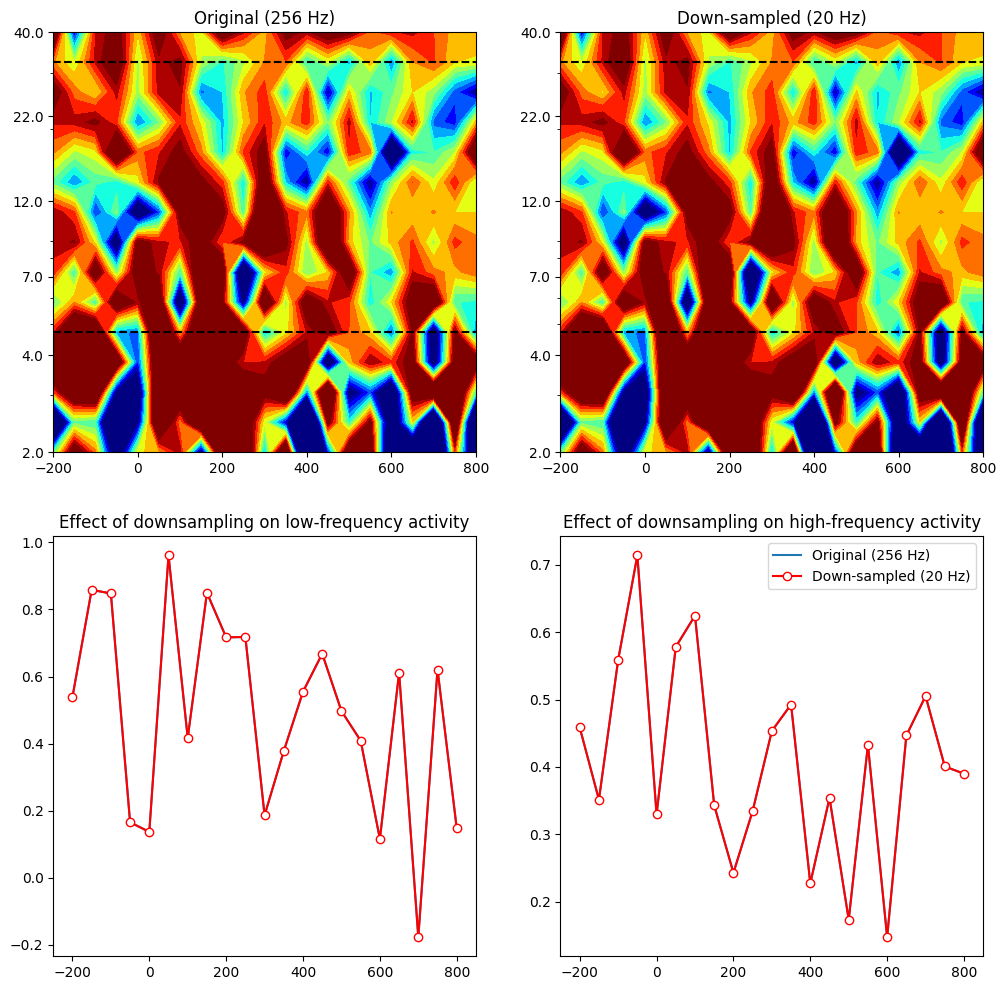

In [53]:
# Figure 27.8

# Downsample the time series
ds_timesidx = np.array([np.argmin(np.abs(times2save - t)) for t in np.arange(-200, 801, 50)])  # Downsampled times
lofreq = np.argmin(np.abs(frequencies - 4.7))
hifreq = np.argmin(np.abs(frequencies - 32))

plt.figure(figsize=(12, 12))

# Original (256 Hz) time-frequency plot
plt.subplot(221)
plt.contourf(times2save, frequencies, tf_corrdata[:, :, 1], 40, cmap='jet', extend='both')
plt.plot(times2save, [frequencies[lofreq]] * len(times2save), 'k--')
plt.plot(times2save, [frequencies[hifreq]] * len(times2save), 'k--')
plt.clim(clim)
plt.xlim([-200, 800])
plt.yscale('log')
plt.yticks(np.round(np.logspace(np.log10(frequencies[0]), np.log10(frequencies[-1]), 6)), np.round(np.logspace(np.log10(frequencies[0]), np.log10(frequencies[-1]), 6)))
plt.title('Original (256 Hz)')

# Downsampled (20 Hz) time-frequency plot
plt.subplot(222)
plt.contourf(times2save[ds_timesidx], frequencies, tf_corrdata[:, ds_timesidx, 1], 40, cmap='jet', extend='both')
plt.plot(times2save[ds_timesidx], [frequencies[lofreq]] * len(times2save[ds_timesidx]), 'k--')
plt.plot(times2save[ds_timesidx], [frequencies[hifreq]] * len(times2save[ds_timesidx]), 'k--')
plt.clim(clim)
plt.xlim([-200, 800])
plt.yscale('log')
plt.yticks(np.round(np.logspace(np.log10(frequencies[0]), np.log10(frequencies[-1]), 6)), np.round(np.logspace(np.log10(frequencies[0]), np.log10(frequencies[-1]), 6)))
plt.title('Down-sampled (20 Hz)')

# Effect of downsampling on low-frequency activity
plt.subplot(223)
print(tf_corrdata[lofreq, :, 1].shape, EEG['times'][0].shape)
plt.plot(times2save, tf_corrdata[lofreq, :, 1])
plt.plot(times2save[ds_timesidx], tf_corrdata[lofreq, ds_timesidx, 1], 'ro-', markerfacecolor='w')
# plt.xlim([-200, 800])
# plt.ylim([0.25, 0.65])
plt.title('Effect of downsampling on low-frequency activity')

# Effect of downsampling on high-frequency activity
plt.subplot(224)
plt.plot(times2save, tf_corrdata[hifreq, :, 1])
plt.plot(times2save[ds_timesidx], tf_corrdata[hifreq, ds_timesidx, 1], 'ro-', markerfacecolor='w')
# plt.xlim([-200, 800])
# plt.ylim([-0.1, 0.6])
plt.title('Effect of downsampling on high-frequency activity')
plt.legend(['Original (256 Hz)', 'Down-sampled (20 Hz)'])

plt.show()